# Kernel Composition

Using the Example from Section5.4.3 of Gaussian Processes for Machine Learning. \
The use of composite kernel not only provides an good fit for the data; it also allows for insights into the models properties by interpretation of the adapted hyperparameters.

In [1]:
import gpflow as gp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary
import pandas

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
gp.config.set_default_summary_fmt("notebook")

# Data

Download the data and format so usable. \
Also split the data so can check out predictions.

In [23]:
from sklearn.datasets import fetch_openml

def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []
    print(ml_data.data.year.values)
    y = ml_data.data.year.values
    m = ml_data.data.month.values
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

In [24]:
X,y = load_mauna_loa_atmospheric_co2()
X = X.reshape(-1,1)
y = y.reshape(-1,1)
lenx=X.shape[0]
leny=y.shape[0]
split_idx=int(70*lenx/100)
X_train = X[:split_idx,:]
X_test = X[split_idx:,:]
y_train = y[:split_idx,:]
y_test = y[split_idx:,:]

[1958. 1958. 1958. ... 2001. 2001. 2001.]


# Kernels
$k_1$ is selected to model the overall increasing trend seen in the data. This uses the Squared exponential covariance function. \
$k_2$ is selected to model seasonal variation; since the data indicates that this variation is not exactly periodic we include the product with the squared exponential to allow decay away from exact periodicity. \
$k_3$ is selected to model small medium-term irregularities. This is done using the Rational Quadractic. \
Finally, $k_4$ is selected as the noise component of the model.

In [25]:
k1 = gp.kernels.RBF(variance=66.0**2,lengthscales=67.0)
k2 = gp.kernels.RBF(variance=2.4**2,lengthscales=90.0) \
    *gp.kernels.Periodic(gp.kernels.SquaredExponential(lengthscales=1.3),period=1.0)
k3 = gp.kernels.RationalQuadratic(variance=0.66**2,lengthscales=1.2, alpha=0.78)
k4 = gp.kernels.RBF(variance=0.18**2,lengthscales=0.134) \
    +gp.kernels.White(variance=0.19**2)

k = k1+k2+k3+k4

In [29]:
model = gp.models.GPR(data=(X_train, y_train), kernel=k, mean_function=None)
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,4356
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,66.8859
GPR.kernel.kernels[1].kernels[0].variance,Parameter,Softplus,,True,(),float64,5.83162
GPR.kernel.kernels[1].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,90.0159
GPR.kernel.kernels[1].kernels[1].base_kernel.variance,Parameter,Softplus,,True,(),float64,1.17656
GPR.kernel.kernels[1].kernels[1].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.766068
GPR.kernel.kernels[1].kernels[1].period,Parameter,Softplus,,True,(),float64,0.999681
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.254369
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1.12458
GPR.kernel.kernels[2].alpha,Parameter,Softplus,,True,(),float64,0.686121


In [27]:
optimiser = gp.optimizers.Scipy()
opt_logs = optimiser.minimize(model.training_loss,
                              variables=model.trainable_variables,
                              options=dict(disp=True, maxiter=100))

In [28]:
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,4356
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,66.8859
GPR.kernel.kernels[1].kernels[0].variance,Parameter,Softplus,,True,(),float64,5.83162
GPR.kernel.kernels[1].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,90.0159
GPR.kernel.kernels[1].kernels[1].base_kernel.variance,Parameter,Softplus,,True,(),float64,1.17656
GPR.kernel.kernels[1].kernels[1].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.766068
GPR.kernel.kernels[1].kernels[1].period,Parameter,Softplus,,True,(),float64,0.999681
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.254369
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1.12458
GPR.kernel.kernels[2].alpha,Parameter,Softplus,,True,(),float64,0.686121


We can now examine and interpret our hyperparameters which optimise the marginal likelihood. 

The long term tend has a magnitude 66ppm and the lengthscale of this is 66.7years. The medium term effects, modelled by the rational quadratic, has a small value for alpha which allows for covariance at many different lengthscales.

The hyperparameters for the decaying periodic contribution are the magnitude of 2.41ppm, decay-time of 90 years and a periodic component of 0.9. The long decay-time shows the data have a very close to periodic component in the short term.

For the noise components, we get the magnitude for the correlated component to be 0.19 ppm, a lengthscale of 1.4 months and independent noise magnitude of 0.16ppm. Thus, the correlation length for noise component is indeed inferred to be short, and the total magnitude of the noise $\sqrt{0.19^2+0.16^2}=0.24$ppm. This indicates that the data can be explained well by the model.

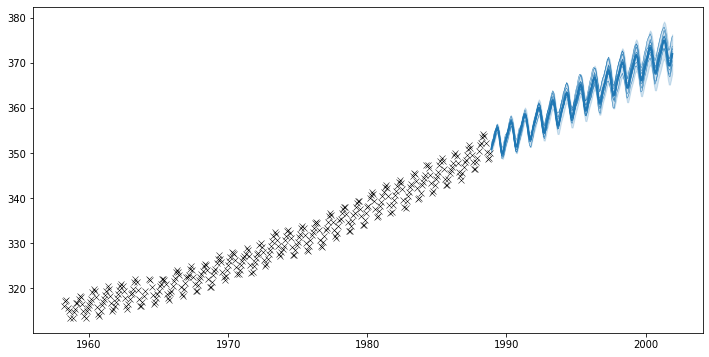

In [30]:
mu_s, cov_s = model.predict_f(X_test)

tf.random.set_seed(103)  # for reproducibility
samples = model.predict_f_samples(X_test, 10) 

## plot
plt.figure(figsize=(12, 6))
plt.plot(X_train, y_train, "kx", mew=0.5)
plt.plot(X_test, mu_s, "C0", lw=2)
plt.fill_between(
    X_test[:, 0],
    mu_s[:, 0] - 1.96 * np.sqrt(cov_s[:, 0]),
    mu_s[:, 0] + 1.96 * np.sqrt(cov_s[:, 0]),
    color="C0",
    alpha=0.2,
)

plt.plot(X_test, samples[:, :, 0].numpy().T, "C0", linewidth=0.5);

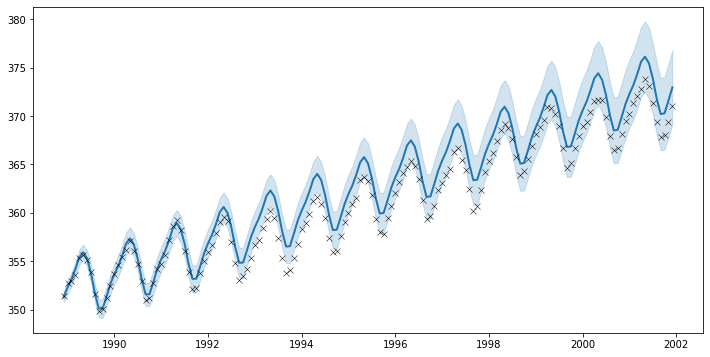

In [83]:
plt.figure(figsize=(12, 6))
plt.plot(X_test, mu_s, "C0", lw=2)
plt.plot(X_test, y_test,"kx",mew=0.5)
plt.fill_between(
    X_test[:, 0],
    mu_s[:, 0] - 1.96 * np.sqrt(cov_s[:, 0]),
    mu_s[:, 0] + 1.96 * np.sqrt(cov_s[:, 0]),
    color="C0",
    alpha=0.2,
);

Can see that fitted line is larger than the true data and the lower interval level only just captures most of the data.